In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The model

This style of modeling is often called the "piecewise exponential model", or PEM. It is the simplest case where we estimate the *hazard* of an event occurring in a time period as the outcome, rather than estimating the *survival* (ie, time to event) as the outcome.

Recall that, in the context of survival modeling, we have two models:

1. A model for **Survival ($S$)**, ie the probability of surviving to time $t$:

  $$ S(t)=Pr(Y > t) $$

2. A model for the **instantaneous *hazard* $\lambda$**, ie the probability of a failure event occuring in the interval [$t$, $t+\delta t$], given survival to time $t$:

  $$ \lambda(t) =  \lim_{\delta t \rightarrow 0 } \; \frac{Pr( t \le Y \le t + \delta t | Y > t)}{\delta t} $$


By definition, these two are related to one another by the following equation:

  $$ \lambda(t) = \frac{-S'(t)}{S(t)} $$
  
Solving this, yields the following:

  $$ S(t) = \exp\left( -\int_0^t \lambda(z) dz \right) $$

This model is called the **piecewise exponential model** because of this relationship between the Survival and hazard functions.  It's piecewise because we are not estimating the *instantaneous* hazard; we are instead breaking time periods up into pieces and estimating the hazard for each piece.

There are several variations on the PEM model implemented in `survivalstan`. In this notebook, we are exploring just one of them.

### A note about data formatting 

When we model *Survival*, we typically operate on data in time-to-event form. In this form, we have one record per `Subject` (ie, per patient). Each record contains `[event_status, time_to_event]` as the outcome. This data format is sometimes called *per-subject*.

When we model the *hazard* by comparison, we typically operate on data that are transformed to include one record per `Subject` per `time_period`.  This is called *per-timepoint* or *long* form.

All other things being equal, a model for *Survival* will typically estimate more efficiently (faster & smaller memory footprint) than one for *hazard* simply because the data are larger in the per-timepoint form than the per-subject form. The benefit of the *hazard* models is increased flexibility in terms of specifying the baseline hazard, time-varying effects, and introducing time-varying covariates.

In this example, we are demonstrating use of the standard **PEM survival model**, which uses data in long form. The `stan` code expects to recieve data in this structure.

## Stan code for the model

This model is provided in `survivalstan.models.pem_survival_model`. Let's take a look at the stan code. 

In [14]:
print(survivalstan.models.pem_survival_model)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>

data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int<

## Simulate survival data 

In order to demonstrate the use of this model, we will first simulate some survival data using `survivalstan.sim.sim_data_exp_correlated`. As the name implies, this function simulates data assuming a constant hazard throughout the follow-up time period, which is consistent with the Exponential survival function.

This function includes two simulated covariates by default (`age` and `sex`). We also simulate a situation where hazard is a function of the simulated value for `sex`. 

We also center the `age` variable since this will make it easier to interpret estimates of the baseline hazard.


In [15]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl
INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


*Aside: In order to make this a more reproducible example, this code is using a file-caching function `stancache.cached` to wrap a function call to `survivalstan.sim.sim_data_exp_correlated`. *

## Explore simulated data

Here is what these data look like - this is `per-subject` or `time-to-event` form:

In [16]:
d.head()

,age,sex,rate,true_t,t,event,index,age_centered
0,56,male,0.082085,3.690371,3.690371,True,0,0.61
1,53,male,0.082085,1.574213,1.574213,True,1,-2.39
2,43,male,0.082085,29.095240,20.000000,False,2,-12.39
3,50,male,0.082085,1.017584,1.017584,True,3,-5.39
4,45,male,0.082085,40.317564,20.000000,False,4,-10.39


*It's not that obvious from the field names, but in this example "subjects" are indexed by the field `index`.*

We can plot these data using `lifelines`, or the rudimentary plotting functions provided by `survivalstan`.

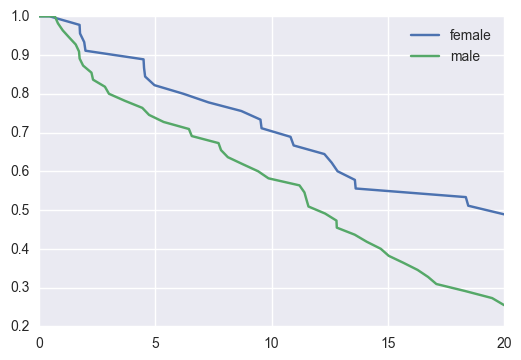

In [17]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

## Transform to `long` or `per-timepoint` form

Finally, since this is a PEM model, we transform our data to `long` or `per-timepoint` form.

In [18]:
dlong = survivalstan.prep_data_long_surv(df=d, event_col='event', time_col='t')
dlong.sort_values(['index','end_time'], inplace=True)

We now have one record per timepoint (distinct values of `end_time`) per subject (`index`, in the original data frame).

In [20]:
dlong.query('index == 0')

,age,sex,rate,true_t,t,event,index,age_centered,key,end_time,end_failure
22,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.447637,False
24,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.676653,False
63,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,0.810536,False
3,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.017584,False
7,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.292124,False
1,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.574213,False
64,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.717213,False
46,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.740919,False
8,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.743126,False
47,56,male,0.082085,3.690371,3.690371,True,0,0.61,1,1.760568,False


## Fit stan model

Now, we are ready to fit our model using `survivalstan.fit_stan_survival_model`. 

We pass a few parameters to the fit function, many of which are required. See ?survivalstan.fit_stan_survival_model for details. 

Similar to what we did above, we are asking `survivalstan` to cache this model fit object. See [stancache](http://github.com/jburos/stancache) for more details on how this works. Also, if you didn't want to use the cache, you could omit the parameter `FIT_FUN` and `survivalstan` would use the standard pystan functionality.


In [ ]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = survivalstan.models.pem_survival_model,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache
INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_25_1.model_code_49777972005.pystan_2_12_0_0.stanmodel.pkl
INFO:stancache.stancache:StanModel: Loading result from cache
INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache
INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_25_1.model_code_49777972005.pystan_2_12_0_0.stanfit.chains_4.data_23144534760.iter_5000.seed_9001.pkl
INFO:stancache.stancache:sampling: Starting execution


## Superficial review of convergence

We will note here some top-level summaries of posterior draws -- this is a minimal example so it's unlikely that this model converged very well. 

In practice, you would want to do a lot more investigation of convergence issues, etc. For now the goal is to demonstrate the functionalities available here.

We can summarize posterior estimates for a single parameter, (e.g. the built-in Stan parameter `lp__`):

In [8]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean         sd        2.5%         50%      97.5%      Rhat
lp__ -253.335475  9.675363  41.049088 -322.754154 -256.689061 -171.68023  1.165648


Or, for sets of parameters with the same name:

In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[0]   0.026639  0.003405  0.152263 -0.262139  0.013340  0.377156  1.003182
log_baseline_raw[1]   0.021748  0.003531  0.157924 -0.261101  0.009023  0.392666  1.001434
log_baseline_raw[2]   0.018438  0.003457  0.154584 -0.304612  0.009754  0.380596  1.002753
log_baseline_raw[3]   0.023526  0.003437  0.153700 -0.265876  0.010971  0.389070  1.004354
log_baseline_raw[4]   0.018647  0.003372  0.150803 -0.296769  0.010733  0.372287  1.000125
log_baseline_raw[5]   0.018729  0.003476  0.155467 -0.292275  0.009194  0.389178  0.999966
log_baseline_raw[6]   0.016554  0.003361  0.150312 -0.288491  0.009149  0.363801  0.999736
log_baseline_raw[7]   0.016617  0.003537  0.158170 -0.305746  0.006724  0.391216  1.000555
log_baseline_raw[8]   0.024833  0.003395  0.151840 -0.284137  0.015196  0.354273  1.002626
log_baseline_raw[9]   0.016214  0.003582  0.160210 -0.296916  0.010321  0.378393  1.002051

It's also not uncommon to graphically summarize the `Rhat` values, to get a sense of similarity among the chains for particular parameters.  

/Users/jburos/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


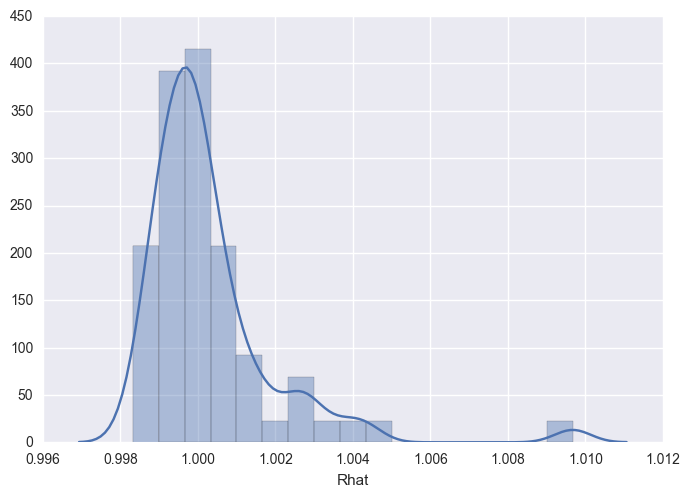

In [10]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

## Plot posterior estimates of parameters

We can use `plot_coefs` to summarize posterior estimates of parameters. 

In this basic `pem_survival_model`, we estimate a parameter for baseline hazard for each observed timepoint which is then adjusted for the duration of the timepoint.  For consistency, the baseline values are normalized to the *unit time* given in the input data. This allows us to compare hazard estimates across timepoints without having to know the duration of a timepoint. *(in general, the duration-adjusted hazard paramters are suffixed with `_raw` whereas those which are unit-normalized do not have a suffix).*

In this model, the baseline hazard is parameterized by two components -- there is an overall mean across all timepoints (`log_baseline_mu`) and some variance per timepoint (`log_baseline_tp`). The degree of variance is estimated from the data as `log_baseline_sigma`. All components have weak default priors. See the stan code above for details.

In this case, the model estimates a minimal degree of variance across timepoints, which is good given that the simulated data assumed a constant hazard over time. 


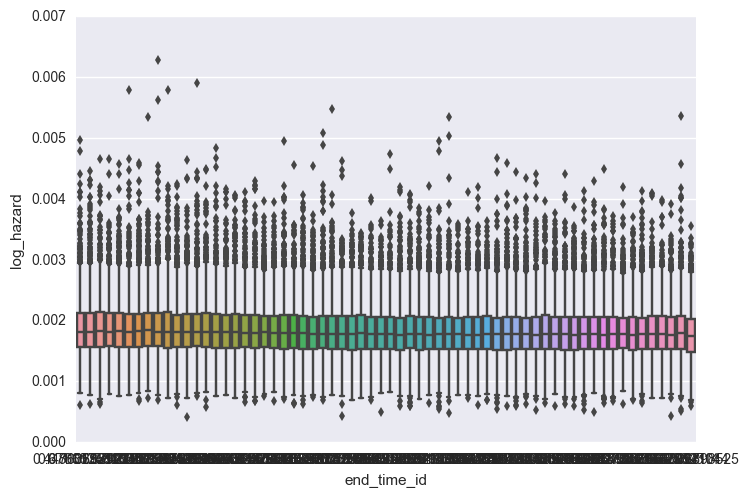

In [11]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

We can also summarize the posterior estimates for our `beta` coefficients. This is actually the default behavior of `plot_coefs`. Here we hope to see the posterior estimates of beta coefficients include the value we used for our simulation (0.5).

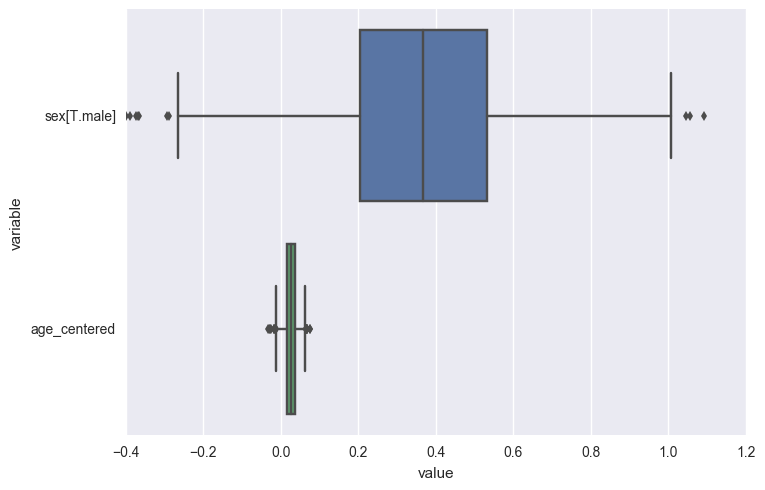

In [12]:
survivalstan.utils.plot_coefs([testfit])

## Posterior predictive checking

Finally, `survivalstan` provides some utilities for posterior predictive checking.

The goal of posterior-predictive checking is to compare the uncertainty of model predictions to observed values.

We are not doing *true* out-of-sample predictions, but we are able to sanity-check our model's calibration. We expect approximately 5% of observed values to fall outside of their corresponding 95% posterior-predicted intervals.

By default, `survivalstan`'s plot_pp_survival method will plot whiskers at the 2.5th and 97.5th percentile values, corresponding to 95% predicted intervals.

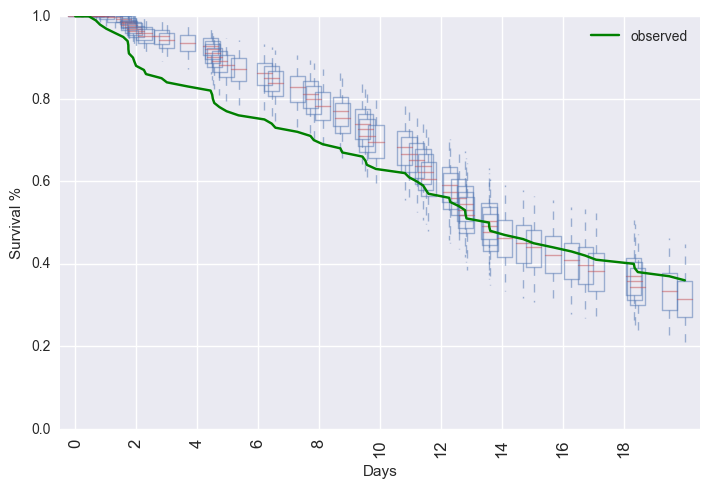

In [13]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

We can also summarize and plot survival by our covariates of interest, provided they are included in the original dataframe provided to `fit_stan_survival_model`.

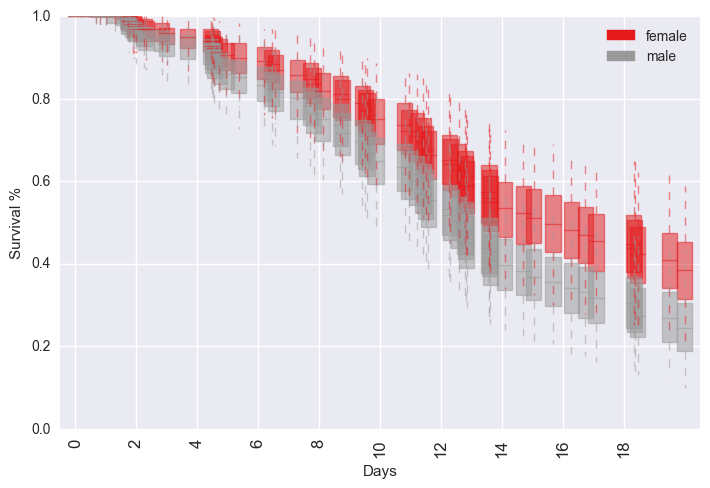

In [17]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')

This plot can also be customized by a variety of aesthetic elements

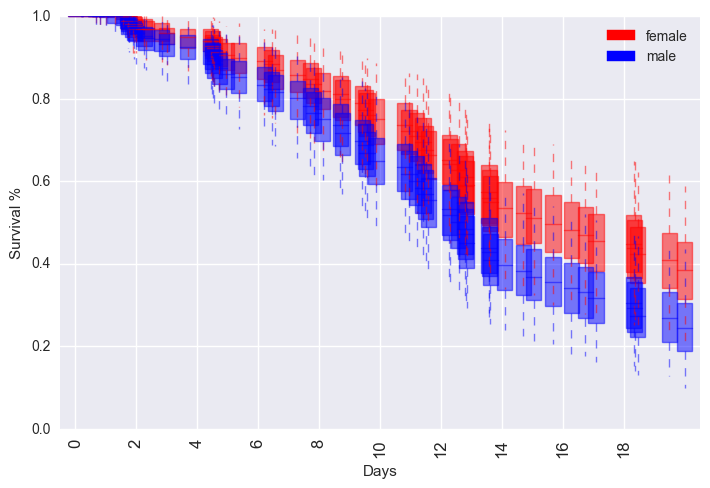

In [18]:
survivalstan.utils.plot_pp_survival([testfit], by='sex', pal=['red', 'blue'])

## Building up the plot semi-manually, for more customization

We can also access the utility methods within `survivalstan.utils` to more or less produce the same plot. This sequence is intended to both illustrate how the above-described plot was constructed, and expose some of the 
functionality in a more concrete fashion.

Probably the most useful element is being able to summarize & return posterior-predicted values to begin with:

In [14]:
ppsurv = survivalstan.utils.prep_pp_survival_data([testfit], by='sex')

Here are what these data look like:

In [19]:
ppsurv.head()

,iter,model_cohort,sex,level_3,event_time,survival
0,0,test model,female,0,0.000000,1.000000
1,0,test model,female,1,1.717213,1.000000
2,0,test model,female,2,1.743126,0.970087
3,0,test model,female,3,1.940485,0.940175
4,0,test model,female,4,1.994993,0.910262


(Note that this itself is a summary of the posterior draws returned by `survivalstan.utils.prep_pp_data`. In this case, the survival stats are summarized by values of `['iter', 'model_cohort', by]`. 

We can then call out to `survivalstan.utils._plot_pp_survival_data` to construct the plot. In this case, we overlay the posterior predicted intervals with observed values.

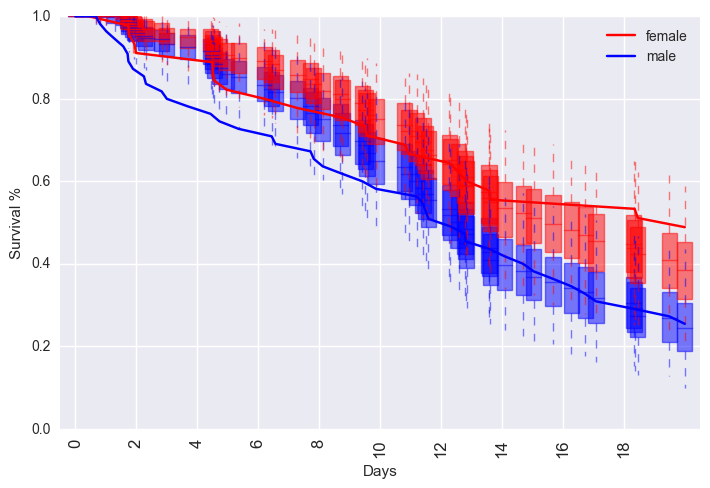

In [16]:
subplot = plt.subplots(1, 1)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "male"').copy(),
                                          subplot=subplot, color='blue', alpha=0.5)
survivalstan.utils._plot_pp_survival_data(ppsurv.query('sex == "female"').copy(),
                                          subplot=subplot, color='red', alpha=0.5)
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t',
                                          color='red', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t',
                                          color='blue', label='male')
plt.legend()